In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import MaxPooling1D, Conv1D
from keras.layers import GRU, LSTM, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Reshape 
from keras.layers import Lambda 
from keras.backend import log

from keras import regularizers

from sklearn.metrics import confusion_matrix
import itertools

from UtilNNDL import create_window_data
from UtilNNDL import plot_hist
from UtilNNDL import prepare_data
from UtilNNDL import plot_confusion_matrix
from UtilNNDL import bandpass_cnt
from UtilNNDL import exponential_running_standardize


RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Using TensorFlow backend.


In [2]:
#Prepare the data by taking out nans and dividing into test and train
file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
train_data, test_data, train_labels, test_labels = prepare_data(file_path, 
                                                                num_test_samples = 50, 
                                                                verbose= False, 
                                                                return_all=True,
                                                                num_files =9)
print train_data.shape
print train_labels.shape
print test_data.shape
print test_labels.shape

(2108, 22, 1000)
(2108, 4)
(450, 22, 1000)
(450, 4)


In [62]:
n = 1
train_data = train_data['A0{}T'.format(n)]
train_labels = train_labels['A0{}T'.format(n)]
test_data = test_data['A0{}T'.format(n)]
test_labels = test_labels['A0{}T'.format(n)]

/home/carla/Documents/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [3]:
#assist numerical stability
train_data = train_data*(1e6)
test_data = test_data*(1e6)

In [4]:
#Bandpass filter the data
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2)
print train_data.shape
print test_data.shape
for i,a in enumerate(train_data):
    train_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)
for i,a in enumerate(test_data):
    test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
print train_data.shape
print test_data.shape

(2108, 1000, 22)
(450, 1000, 22)
(2108, 1000, 22)
(450, 1000, 22)


In [5]:
#Standardize the data
for i,a in enumerate(train_data):
    train_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
for i,a in enumerate(test_data):
    test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2) 
print train_data.shape
print test_data.shape

(2108, 22, 1000)
(450, 22, 1000)


In [6]:
#Augment the data into a bigger set by windowing
windows = 10
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=windows)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=windows)
print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape 

(21080, 22, 512)
(21080, 4)
(4500, 22, 512)
(4500, 4)


In [7]:
#Add an additional axis for Conv2D
traindata2d = train_data_sliced.reshape(train_data_sliced.shape[0], train_data_sliced.shape[2], train_data_sliced.shape[1], 1)
testdata2d = test_data_sliced.reshape(test_data_sliced.shape[0], test_data_sliced.shape[2], test_data_sliced.shape[1], 1)
print traindata2d.shape
print testdata2d.shape

(21080, 512, 22, 1)
(4500, 512, 22, 1)


In [8]:
# Modify test data to run model on another subject
_, test_data_orig, _, test_labels_orig = prepare_data(file_path, 
                                            num_test_samples=50, 
                                            verbose=False, 
                                            return_all=False,
                                            num_files=9)

In [9]:
test_data_all = []
test_labels_all = []
for n in range(1,10):
    test_data = test_data_orig['A0{}T'.format(n)]
    test_labels = test_labels_orig['A0{}T'.format(n)]
    #print test_data.shape
    #print test_labels.shape

    #assist numerical stability
    test_data = test_data*(1e6)
    test_data = test_data.swapaxes(1,2)
    for i,a in enumerate(test_data):
        test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
    #print test_data.shape

    #standardize
    for i,a in enumerate(test_data):
        test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)

    test_data = test_data.swapaxes(1,2) 
    test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)

    test_data_sliced = test_data_sliced[:500,:]
    test_labels_sliced = test_labels_sliced[:500,:]
    #print test_data_sliced.shape
    #print test_labels_sliced.shape 

    testdata2d = test_data_sliced.reshape(test_data_sliced.shape[0], test_data_sliced.shape[2], test_data_sliced.shape[1], 1)
    #print testdata2d.shape
    
    test_data_all.append(testdata2d)
    test_labels_all.append(test_labels_sliced)
    
print(len(test_data_all))
print(len(test_labels_all))

9
9


In [12]:
# Conv2D + LSTM
model = Sequential()
model.add(Conv2D(40, kernel_size=(25,1), activation='relu', data_format='channels_last', input_shape=(512, 22, 1), 
                 kernel_initializer='glorot_normal')) 
model.add(Conv2D(40, kernel_size=(1,22), activation='relu', kernel_initializer='glorot_normal') ) 
model.add(BatchNormalization(axis=-1))
#model.add(Lambda(lambda x: x ** 2))
model.add(MaxPooling2D(pool_size=(60,1), strides = (15,1)))
#model.add(Lambda(lambda x: log(x)))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(4, activation='softmax',kernel_initializer='glorot_normal'))#, kernel_regularizer=regularizers.l2(0.05)))
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(traindata2d,train_labels_sliced,epochs=10,validation_split=0.25,batch_size=150)

'''test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=32)
print "Test Score: {}".format(test_score)
print "Windows: {}".format(windows)
test_predict = model.predict(testdata2d, batch_size=32)

cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
unique, count = np.unique(np.argmax(test_labels_sliced,axis=1),return_counts=True)
print count 
plt.figure(0)
plot_confusion_matrix(cm, classes=["1","2","3","4"])
print np.argmax(test_predict,axis=1).shape
plt.figure(1)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plt.figure(2)
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 488, 22, 40)       1040      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 488, 1, 40)        35240     
_________________________________________________________________
batch_normalization_2 (Batch (None, 488, 1, 40)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 1, 40)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 1, 40)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1160)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 4644      
Total para

'test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=32)\nprint "Test Score: {}".format(test_score)\nprint "Windows: {}".format(windows)\ntest_predict = model.predict(testdata2d, batch_size=32)\n\ncm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))\nunique, count = np.unique(np.argmax(test_labels_sliced,axis=1),return_counts=True)\nprint count \nplt.figure(0)\nplot_confusion_matrix(cm, classes=["1","2","3","4"])\nprint np.argmax(test_predict,axis=1).shape\nplt.figure(1)\nplot_hist([hist.history[\'acc\'],hist.history[\'val_acc\']],[\'Training Accuracy\',\'Val Accuracy\'],title=\'Accuracies\')\nplt.figure(2)\nplot_hist([hist.history[\'loss\'],hist.history[\'val_loss\']],[\'Training Loss\',\'Val Loss\'],title=\'Loss\')'

Subject 1
500/500 [==============================] - 0s 179us/step
Test Score: [1.013595953464508, 0.58599999809265135]
Subject 2
500/500 [==============================] - 0s 178us/step
Test Score: [1.3885438137054444, 0.29200000059604647]
Subject 3
500/500 [==============================] - 0s 183us/step
Test Score: [1.0980460062026978, 0.53399999904632567]
Subject 4
500/500 [==============================] - 0s 180us/step
Test Score: [1.3475265607833862, 0.3860000014305115]
Subject 5
500/500 [==============================] - 0s 177us/step
Test Score: [1.5139460563659668, 0.23000000017881395]
Subject 6
500/500 [==============================] - 0s 181us/step
Test Score: [1.3973660783767701, 0.31600000143051149]
Subject 7
500/500 [==============================] - 0s 176us/step
Test Score: [1.319798981666565, 0.39200000047683714]
Subject 8
500/500 [==============================] - 0s 178us/step
Test Score: [1.2537166395187378, 0.44600000000000001]
Subject 9
500/500 [================

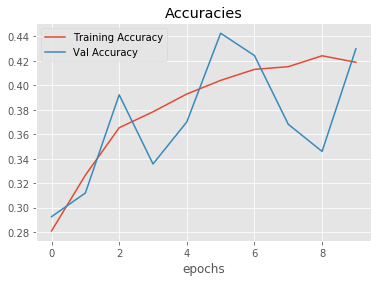

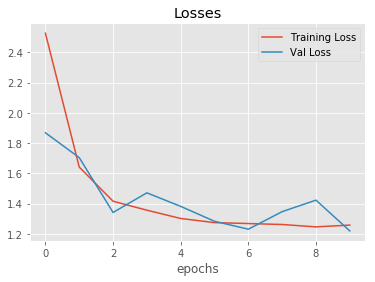

In [13]:
conf = []
test_score = []

for i in range(9):
    print "Subject {}".format(i+1)
    test_score_i = model.evaluate(test_data_all[i], test_labels_all[i], batch_size=64)
    print "Test Score: {}".format(test_score_i)
    test_predict = model.predict(test_data_all[i], batch_size=16)
    cm = confusion_matrix(np.argmax(test_labels_all[i],axis=1),np.argmax(test_predict,axis=1))
    conf.append(cm)
    test_score.append(test_score_i)
    
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

In [14]:
np.save('Best Models/Variables/shallow_hist_all_bad',hist.history)
np.save('Best Models/Variables/shallow_testacc_all_bad',test_score)
np.save('Best Models/Variables/shallow_conf_all_bad',conf)

In [ ]:
### test_predict = np.argmax(test_predict, axis=1)1
print test_predict.shape 

In [60]:
w = 0
print test_predict[(w*windows):(w*windows+512)]
print np.bincount(test_predict[(w*windows):(w*windows+512)])

[2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 2 2 2 2 3 2 3 2 3 2 2 3 2 3 3 2 2 2 2 3 2 3 2 2 2 3 2 0 0 2
 2 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 2 2 2 3 3 3 3 3 3 2 3 3 3 3
 2 3 3 2 3 3 3 2 3 3 2 3 3 3 2 2 2 2 2 3 3 2 2 2 2 2 2 3 3 2 2 2 2 2 3 3 3
 2 2 3 2 3 3 2 2 2 3 2 2 3 2 2 2 2 2 2 3 2 2 2 2 2 2 3 2 2 2 2 2 2 2 3 2 2
 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 2 0 0 2
 2 2 2 2 2 2 2 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 2 1 0 1 1 1 1 1 1 1 0 1 1 1 1 2 1 0 1 1 2 2 2 1 0 2 1 1 0 0 1 0 0 0 0 0 0
 1 0 0 0 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [50]:
test_predict_ave = np.zeros(test_predict.shape[0]/windows)
print test_predict_ave.shape
for w in range(test_labels.shape[0]):
    test_predict_ave[w] = np.argmax(np.bincount(test_predict[(w*windows):(w*windows+512)]))
print np.argmax(test_labels, axis=1)
print test_predict_ave 
print np.rint(test_predict_ave)

(50,)
[0 2 0 3 1 3 3 2 3 3 2 1 3 2 0 1 1 1 2 1 3 2 3 1 2 0 3 0 2 3 0 2 0 1 1 0 3
 0 3 2 2 0 2 1 1 0 2 0 1 0]
[ 0.  1.  1.  3.  3.  3.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  3.  3.  3.  2.  2.  2.  2.  2.  2.  2.  2.  3.  0.  0.  0.  0.  0.  0.
  3.  2.  2.  2.  2.  0.  2.  2.  2.  2.  0.  0.  0.  0.]
[ 0.  1.  1.  3.  3.  3.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  3.  3.  3.  2.  2.  2.  2.  2.  2.  2.  2.  3.  0.  0.  0.  0.  0.  0.
  3.  2.  2.  2.  2.  0.  2.  2.  2.  2.  0.  0.  0.  0.]


In [ ]:
#Deeper CNN + LSTM (Golmohammadi paper)
model = Sequential()
model.add(Conv2D(16, kernel_size=(22,1), activation='relu', data_format='channels_last', input_shape=(512, 22, 1)))